In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, NMF, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote.csv')
data.head()

,userId,wine,rate
0,5ccd8030-047b-432c-a630-d784ab415756,Valpolicella Ripasso,3
1,df904a46-c461-4233-9d44-6ac11a8bbddc,Astrale,3
2,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Bricco Riva Bianca,3
3,bc79b0e3-064d-4240-86de-e86499f577e8,3/11 Syrah and blend #4,3
4,5ccd8030-047b-432c-a630-d784ab415756,Valpolicella Ripasso Classico Superiore Pojega,4


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Biased','RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Biased, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


## Non-Negative Matrix Factorization

In [3]:
class Nmf (NMF):
    def __init__(self, n_factors, n_epochs, biased, verbose):
       NMF.__init__(self, 
                    n_factors= n_factors, n_epochs = n_epochs,
                      biased= biased, verbose = verbose)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)
        
    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            NMF.fit(self, trainset_fold)
            train_prediction = NMF.test(self, trainset_fold.build_testset())
            prediction = NMF.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = NMF.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        '''Return the k nearest neighbors of user_id'''
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        '''Return the k nearest neighbors of item_id'''
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## SVD and SGD

The minimization is performed by a very straightforward stochastic gradient descent:
* note You can choose to use an unbiased version of this algorithm
* verbose – If True, prints the current epoch. Default is False.

In [4]:
nmf = Nmf(n_factors= 100, n_epochs= 60, biased= True, verbose=False)

nmf.create_reader(data)
predictions = nmf.fit()
#acc
metrics = nmf.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'Non-Negative Matrix Factorization'

metrics['Biased'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

RMSE: 1.6303
RMSE: 1.8781
RMSE: 1.4846
RMSE: 1.6920
RMSE: 1.4831
RMSE: 1.6768
RMSE: 1.5179
RMSE: 1.9085
RMSE: 1.3689
RMSE: 1.4805
###############################################
The Results are: 

Average RMSE on Training Set: 1.4969761665387094
Average RMSE on Test Set: 1.7271916526882698
RMSE: 1.6960
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.6959631257817092
RMSE: 1.6960
MAE:  1.3068
MSE: 2.8763
Precision: 0.10
Recall: 0.10
the acc is 24.61


/tmp/ipykernel_22771/3155765162.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [5]:
nmf2 = Nmf(n_factors= 100, n_epochs= 60, biased= False, verbose=False)

nmf2.create_reader(data)
predictions = nmf2.fit()
#acc
metrics = nmf2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'Non-Negative Matrix Factorization'

metrics['Biased'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

RMSE: 0.3653
RMSE: 1.4611
RMSE: 0.3673
RMSE: 1.3682
RMSE: 0.3507
RMSE: 1.3388
RMSE: 0.3824
RMSE: 1.3202
RMSE: 0.3372
RMSE: 1.3639
###############################################
The Results are: 

Average RMSE on Training Set: 0.3605473075701045
Average RMSE on Test Set: 1.3704475481154756
RMSE: 1.5013
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.501255918137875
RMSE: 1.5013
MAE:  1.1254
MSE: 2.2538
Precision: 0.05
Recall: 0.04
the acc is 34.55


/tmp/ipykernel_22771/3989888284.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_22771/3989888284.py:15: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [6]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Biased,RMSE,MAE,MSE,Precision,Recall,Accuracy
1,2,Non-Negative Matrix Factorization,False,1.501256,1.125402,2.253769,0.048780,0.035061,34.554974
0,1,Non-Negative Matrix Factorization,True,1.695963,1.306756,2.876291,0.104874,0.102941,24.607330


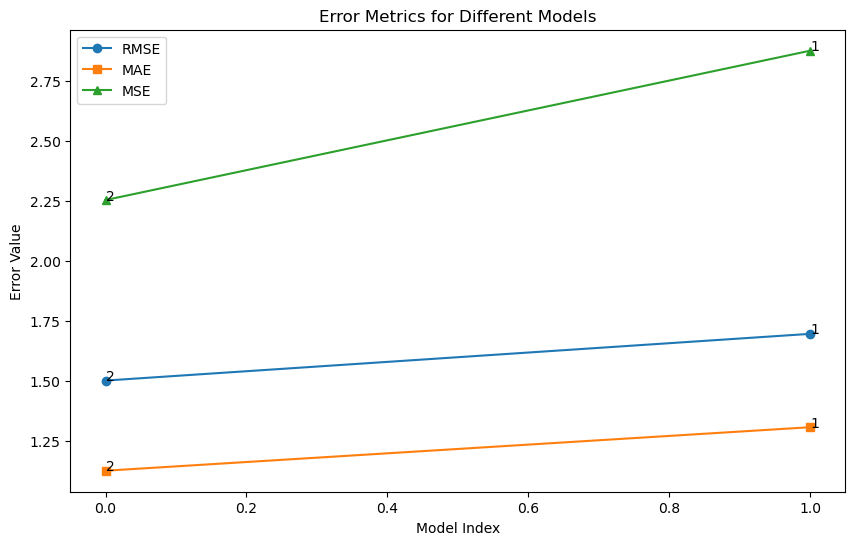

In [7]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

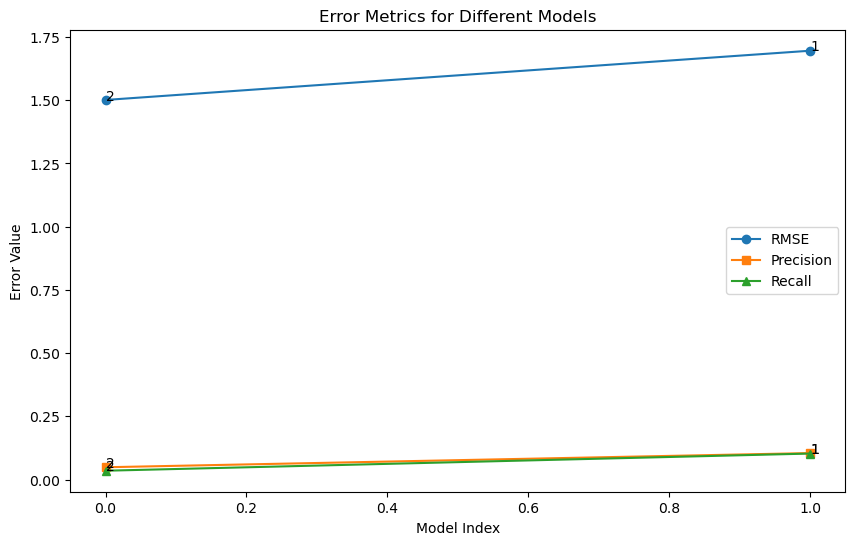

In [8]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

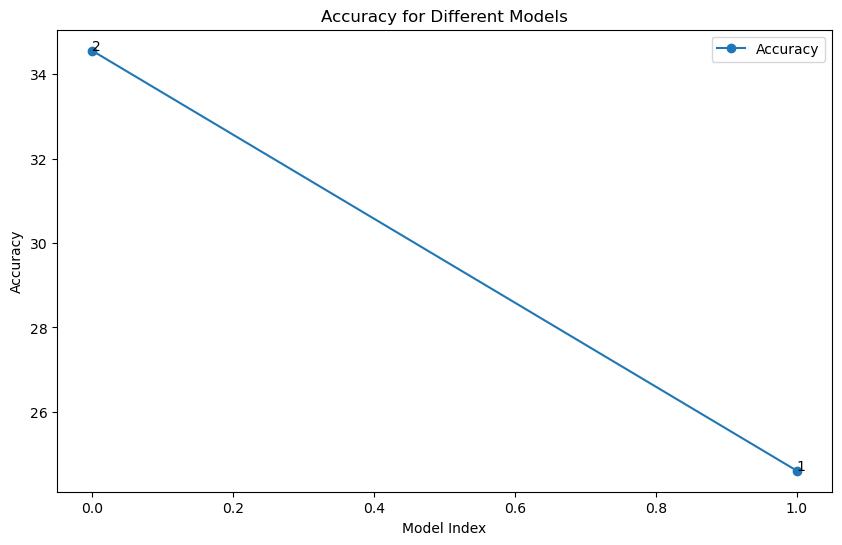

In [9]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [10]:
#recommends items for a given user from predictions

# user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
# top_n = KnnWithMeans.get_top_n_for_user(predictions, user_id)
# print(user_id, [iid for (iid, _) in top_n])
######### better print
user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
top_n = nmf.get_top_n_for_user(predictions, user_id)
print(f"Top items for the user '{user_id}' are:")
for i, (iid, _) in enumerate(top_n, 1):
    print(f"{i}. Item ID: {iid}")

Top items for the user '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7' are:
1. Item ID: Le Grand Saumur
2. Item ID: Théophile Brut Champagne
3. Item ID: Mendoza Pinot Grigio
4. Item ID: Portillo Malbec


In [11]:
# recommneds users for a given item from predictions

# item_id = 'Chardonnay'
# top_n = KnnWithMeans.get_top_n_users_for_item(predictions, item_id)
# print(item_id, [uid for (uid, _) in top_n])
########## better print
item_id = 'Chardonnay'
top_n = nmf.get_top_n_users_for_item(predictions, item_id)
print(f"Top users for the item '{item_id}' are:")
for i, (uid, _) in enumerate(top_n, 1):
    print(f"{i}. User ID: {uid}")

Top users for the item 'Chardonnay' are:
1. User ID: 36fec3ea-e183-491d-b65a-6c7ac90fafa5
2. User ID: c88644be-2c9b-42f0-9c4b-7f8e81795f43


In [12]:
#get the KnnWithMeans for a user from the model
nmf.get_neighbors_uid(user_id=5)

['e019e935-677a-4713-9c68-e19d2db878c4',
 'dcd16582-14d2-4e00-a024-9b5886d29b29',
 '3b1f7bc8-6a23-47e5-97df-043bd1b97f12',
 'bf82194f-6108-4524-9cef-69c0231ac74b',
 '7b8580a6-ec74-44fa-96fe-028257bd61d2',
 '014e4ed1-6f8b-4b25-917d-c167a2acca17',
 'f96944e4-6672-4ff4-beed-96d17801d495',
 'c30006c8-a677-4c8f-9c52-c8f00b48fea4',
 '0c0fb748-ee39-4687-b1a4-65044a48a02f',
 'f8c400a6-ded1-40b8-95d2-a263d05c30ce']

In [13]:
#get the KnnWithMeans for an item from the model
nmf.get_neighbors_iid(item_id=20)

['Tignanello ',
 'Chance',
 'Vipra Rossa Umbria',
 'Chianti classico',
 'Collio bianco riserva',
 'Brachetto Piemonte',
 'Merlot  le vigne di zamo',
 'Les petits buis',
 'Terrano',
 'Morellino di Scansano DOCG terre di talamo']

In [14]:
nmf.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(nmf.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 8 with sim 0.000000000000000
And the baseline estimate is: 4.738063188585016

#####

Note: If the baseline is 2.8918032786885246 then the value is a default value, Otherwise not


In [15]:
df_pred = nmf.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Bishop’s Leap,4.0,2.868852,"{'was_impossible': True, 'reason': 'User and i...",36,1,1.131148
1,5ccd8030-047b-432c-a630-d784ab415756,Valpolicella Classico,3.0,2.868852,"{'was_impossible': True, 'reason': 'User and i...",53,1,0.131148
2,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Pinot Bianco Schulthauser,3.0,2.868852,"{'was_impossible': True, 'reason': 'User and i...",36,0,0.131148
3,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Le Grand Saumur,3.0,2.868852,"{'was_impossible': True, 'reason': 'User and i...",23,0,0.131148
4,bc8f3005-c2c6-4277-9fd7-340248f4e7ec,Montepulciano d'Abruzzo,1.0,3.580706,{'was_impossible': False},8,1,2.580706
5,d229f371-d36c-4e52-8806-fdd41896c689,Chateauneuf-Du-Pape,4.0,2.868852,"{'was_impossible': True, 'reason': 'User and i...",3,1,1.131148
6,70c67292-57ce-4012-a939-5e6ddcb499f8,Gato Negro Cabernet Sauvignon - Merlot,3.0,2.868852,"{'was_impossible': True, 'reason': 'User and i...",1,1,0.131148
7,dd7e04c1-987c-4520-9ab5-c90e86b7dfe1,Taurasi Vigna Cinque Querce,1.0,2.358079,{'was_impossible': False},3,1,1.358079
8,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Passo alle Tremiti Rosato,3.0,1.137329,{'was_impossible': False},36,0,1.862671
9,83128cf9-f07f-4de1-97cf-cbde8d38bc3c,Refosco dal peduncolo rosso,1.0,1.000000,{'was_impossible': False},3,2,0.000000


* best predictions

In [16]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
143,7ed7fb0c-884d-46bf-a14a-205474a0949d,Reserve Merlot,1.0,1.0,{'was_impossible': False},2,3,0.0
150,d229f371-d36c-4e52-8806-fdd41896c689,Müller Thurgau,1.0,1.0,{'was_impossible': False},3,4,0.0
125,3b1f7bc8-6a23-47e5-97df-043bd1b97f12,Moscata D'Asti Casaniere,1.0,1.0,{'was_impossible': False},3,10,0.0
64,e019e935-677a-4713-9c68-e19d2db878c4,Merlot le vigne di zamo,1.0,1.0,{'was_impossible': False},2,4,0.0
184,776b5af7-bb8a-484a-bddb-dadf5dab4621,Muscat de Beaumes-de-Venise,5.0,5.0,{'was_impossible': False},5,2,0.0
9,83128cf9-f07f-4de1-97cf-cbde8d38bc3c,Refosco dal peduncolo rosso,1.0,1.0,{'was_impossible': False},3,2,0.0
10,20e0b694-84a5-4f11-9191-598f924c2947,Neuburger 2019,1.0,1.0,{'was_impossible': False},4,6,0.0
103,8a5ddd23-7ed8-4ac0-9c5d-12ff3b908053,Monterey Pinot Noir,1.0,1.0,{'was_impossible': False},3,1,0.0
113,c3371365-d499-4675-aa68-dbc7b11f0777,Bollicina,1.0,1.0,{'was_impossible': False},3,5,0.0
82,3dd9219a-c64e-4c5a-a61b-aad6a417a69a,Morellino di Scansano DOCG terre di talamo,1.0,1.0,{'was_impossible': False},2,7,0.0


* worst predictions

In [17]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
84,8a5ddd23-7ed8-4ac0-9c5d-12ff3b908053,Altitud Chardonnay,4.0,1.000000,{'was_impossible': False},3,1,3.000000
117,5ccd8030-047b-432c-a630-d784ab415756,Randersacker Sonnenstuhl Silvaner,4.0,1.000000,{'was_impossible': False},53,2,3.000000
161,bc79b0e3-064d-4240-86de-e86499f577e8,3／4 大亂鬥 10,5.0,1.315776,{'was_impossible': False},29,0,3.684224
112,defee34b-7775-4889-b703-92b730d85e70,I Saltari Valpolicella Superiore,5.0,1.168630,{'was_impossible': False},8,1,3.831370
28,bc79b0e3-064d-4240-86de-e86499f577e8,Terroir de Granit Saint Joseph,5.0,1.096179,{'was_impossible': False},29,1,3.903821
12,c3371365-d499-4675-aa68-dbc7b11f0777,Picpoul de Pinet Higues de Beauvignac,5.0,1.000000,{'was_impossible': False},3,2,4.000000
135,4c0b31a0-1287-4efc-b24c-fe850084eafd,Chianti,5.0,1.000000,{'was_impossible': False},2,3,4.000000
165,ce7409cd-2e73-490d-adee-95ed9e8d7b75,Aziano Chianti Classico,5.0,1.000000,{'was_impossible': False},3,1,4.000000
30,86ddb2c4-016f-47ed-8cf9-aa0a3564b7f8,Puntalice,5.0,1.000000,{'was_impossible': False},1,0,4.000000
109,6ff6fb75-4fe9-453f-9c7d-c6ff63ada901,Morandina Valpolicella Ripasso Superiore,5.0,1.000000,{'was_impossible': False},1,1,4.000000
